# Graph Setup

The following notebook will create 2 data sets. One data set will include the edge list for our social network graph. The other data set will include node attributes.

In [1]:
#Import libraries
from pyspark.sql.functions import explode, col, size,  array_except
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [2]:
#Run necessary notebooks
%run Social_Networking_Project/Data-Retrieval.ipynb

In [3]:
friend_count = user.select("user_id", size("friends").alias("friend_count"))

In [4]:
friend_multiple = friend_count.filter(col('friend_count')>1).cache()

In [5]:
friend_multiple.take(2)

[Row(user_id='qVc8ODYU5SZjKXVBgXdI7w', friend_count=14995),
 Row(user_id='j14WgRoU_-2ZE1aw1dXrJg', friend_count=4646)]

In [6]:
friend_single = friend_count.filter(col('friend_count')==1)

In [7]:
friend_single.take(2)

[Row(user_id='n8bbgZJLENE4dC4E743ukQ', friend_count=1),
 Row(user_id='Je6-vkrCJxex_cmREVpLBw', friend_count=1)]

In [8]:
friend_single_users = friend_single.select("user_id").rdd.flatMap(lambda x: x).collect()

In [ ]:
#Remove user ids from the friend list if they exist in the friend_single_users list
user = user.withColumn("friends", array_except(col("friends"), friend_single_users))

In [ ]:
#filter out users with 1 friend
user = user.filter(~col("user_id").isin(friend_single_users))

In [ ]:
# Check if all users in the friends column exist in the user_id column
all_exist = user.select(array_except(col("friends"), col("user_id"))).first()[0]

if all_exist:
    print("All users in the friends column exist in the user_id column.")
else:
    print("Not all users in the friends column exist in the user_id column.")

In [ ]:
#obtain new counts
friend_count = user.select("user_id", size("friends").alias("friend_count"))

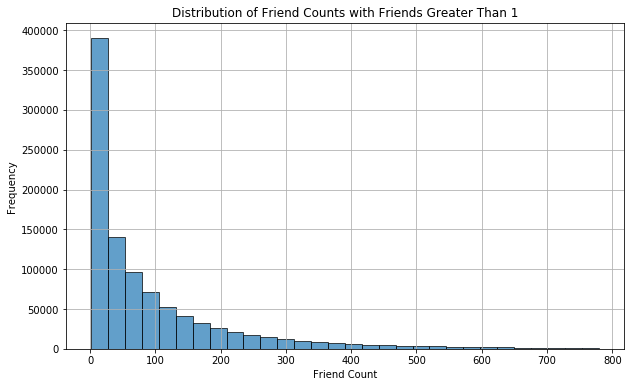

In [5]:
#Distribution of friend counts with more than 1 friend
friend_count_pd = friend_count.select("friend_count").toPandas()
threshold = friend_count_pd['friend_count'].quantile(0.99)
friends_filter = friend_count_pd[friend_count_pd['friend_count'] <= threshold]
# Plotting the distribution of friend counts
plt.figure(figsize=(10, 6))
plt.hist(friends_filter["friend_count"], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Friend Counts with Friends Greater Than 1')
plt.xlabel('Friend Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig("Social_Networking_Project/friend_distribution.png")
plt.show()

In [7]:
stats = friend_count_pd["friend_count"].describe()
for stat,value in stats.items():
    print(f"{stat}: {value}")

count: 994243.0
mean: 105.71899525568699
std: 193.38376737642355
min: 2.0
25%: 12.0
50%: 46.0
75%: 128.0
max: 14995.0


In [30]:
edgelist_df = user.select(user.user_id, explode(user.friends).alias('friend_id'))
edgelist_df = edgelist_df.filter((edgelist_df.user_id != '') & (edgelist_df.friend_id != ''))
edgelist_df = edgelist_df.dropDuplicates(['user_id', 'friend_id'])
edgelist_renamed_df = edgelist_df.withColumnRenamed("user_id", "source") \
                                 .withColumnRenamed("friend_id", "target")

In [31]:
# Show the first few rows of the edgelist
edgelist_df.limit(5).show()

+--------------------+--------------------+
|             user_id|           friend_id|
+--------------------+--------------------+
|---2PmXbF47D870st...|3vNQ9iRBMhlFGt2uX...|
|---2PmXbF47D870st...|4QT83ZgRsTSNJzk_x...|
|---2PmXbF47D870st...|r23IC1UybyeMYPNwU...|
|--XsxD0sMPKjWzApq...|Kz3g9ajWKJliPuITA...|
|--ZNfWKj1VyVElRx6...|--Hhvp8QDcsSa9MV5...|
+--------------------+--------------------+



In [32]:
bucket_name =  'quagliam-bucket-milestone1' ### Change this to your bucket name
proj_directory = f'gs://{bucket_name}/notebooks/jupyter/'

In [ ]:
# Save the edgelist to a CSV file, if needed
edgelist_df.write.csv(f'{proj_directory}/edgelist.csv', header=True)